Dataset Loaded: (208, 224, 224, 3) (208,)


C:\Users\ADMIN\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Class Weights: {0: np.float64(1.6938775510204083), 1: np.float64(0.7094017094017094)}
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4759 - loss: 0.7245 - val_accuracy: 0.3333 - val_loss: 0.7082
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 861ms/step - accuracy: 0.5482 - loss: 0.7003 - val_accuracy: 0.4524 - val_loss: 0.6917
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 864ms/step - accuracy: 0.5843 - loss: 0.6798 - val_accuracy: 0.3095 - val_loss: 0.6992
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 835ms/step - accuracy: 0.5241 - loss: 0.6644 - val_accuracy: 0.5476 - val_loss: 0.6803
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 861ms/step - accuracy: 0.6084 - loss: 0.6625 - val_accuracy: 0.6429 - val_loss: 0.6668
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 858ms/step - accuracy: 0.7470 - loss: 0.6329 - val_accuracy: 0.5000 - val_loss: 0.6972
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 867ms/step - accuracy: 0.5241 - loss: 0.6502 - val_accuracy: 0.5000 - val_loss: 0.7042
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━

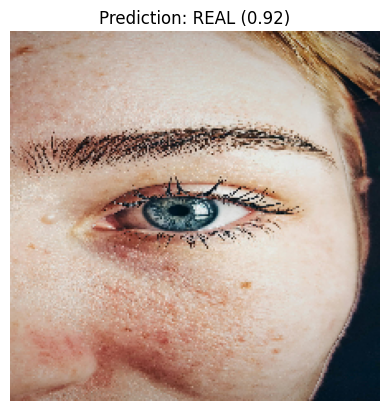

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


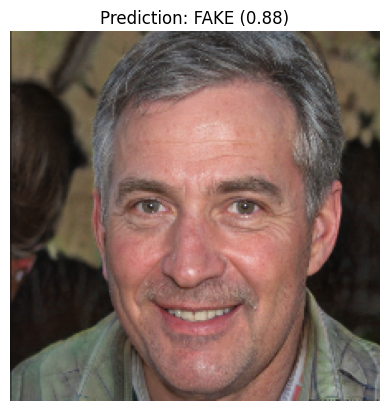

In [2]:
# ==========================
# 1. IMPORT LIBRARIES
# ==========================
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# ==========================
# 2. LOAD DATASET
# ==========================
def load_dataset(real_dir, fake_dir, img_size=(224, 224)):
    data = []
    labels = []

    # Load REAL images
    for img_name in os.listdir(real_dir):
        img_path = os.path.join(real_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            data.append(img)
            labels.append(0)  # 0 = REAL

    # Load FAKE images
    for img_name in os.listdir(fake_dir):
        img_path = os.path.join(fake_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            data.append(img)
            labels.append(1)  # 1 = FAKE

    return np.array(data), np.array(labels)

# Your dataset folders (update paths if needed)
real_path = r"C:\Users\ADMIN\Downloads\ML Project_files\Final\Real"
fake_path = r"C:\Users\ADMIN\Downloads\ML Project_files\Final\Fake"

X, y = load_dataset(real_path, fake_path)
print("Dataset Loaded:", X.shape, y.shape)

# Normalize
X = X.astype("float32") / 255.0
y = to_categorical(y, num_classes=2)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================
# 3. BUILD CNN MODEL
# ==========================
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax")
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# ==========================
# 4. HANDLE CLASS IMBALANCE
# ==========================
y_train_labels = np.argmax(y_train, axis=1)  # convert one-hot to class labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# ==========================
# 5. TRAIN MODEL
# ==========================
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    class_weight=class_weights
)

# ==========================
# 6. PREDICT & SHOW IMAGE
# ==========================
def predict_and_show(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print("❌ Could not load:", img_path)
        return

    img_resized = cv2.resize(img, (224, 224))
    img_norm = img_resized.astype("float32") / 255.0
    img_input = np.expand_dims(img_norm, axis=0)

    prediction = model.predict(img_input)[0]
    class_idx = np.argmax(prediction)

    label = "REAL" if class_idx == 0 else "FAKE"
    confidence = prediction[class_idx]

    # Show image with prediction
    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {label} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

# ==========================
# 7. TEST WITH SAMPLE IMAGES
# ==========================
predict_and_show(r"C:\Users\ADMIN\Downloads\ML Project_files\Final\Real\sample_real.jpg.jpg")
predict_and_show(r"C:\Users\ADMIN\Downloads\ML Project_files\Final\Fake\sample_fake.jpg.png")
